# Amazon Fine Food Reviews- LOGISTIC REGRESSION


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1- Id
2- ProductId - unique identifier for the product
3- UserId - unqiue identifier for the user
4- ProfileName
5- HelpfulnessNumerator - number of users who found the review helpful
6- HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7- Score - rating between 1 and 5
8- Time - timestamp for the review
9- Summary - brief summary of the review
10- Text - text of the review




In [1]:
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)


s1= filtered_data.loc[filtered_data["Score"]>=4].sample(n=11500,random_state=1)
print(s1.shape)

s2= filtered_data.loc[filtered_data["Score"]<=2].sample(n=7500,random_state=95)
print(s2.shape)


C:\Users\santosh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\santosh\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


(11500, 10)
(7500, 10)


In [2]:
data=s1
data=data.append(s2)
data.shape
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
data['Score'] = positiveNegative

In [3]:
sorted_data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final=final.drop_duplicates(subset={"UserId","ProfileName","Time"},keep='first',inplace=False)
print(final.shape)
print(final['Score'].value_counts())

(17984, 10)
positive    11142
negative     6842
Name: Score, dtype: int64


In [4]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

    import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english') 

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 

    str1 = b" ".join(filtered_sentence)
    
    final_string.append(str1)
    i+=1

    
final['CleanedText']=final_string
final.head(3) 


conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None,
             dtype=None)
final.shape

0
Though they might be a bit pricey for just the average dog owner like myself (as opposed to say someone in a profession working with dogs), they're great treats.<br />Perfect size for the quick little snack on the run.<br />And yeah... my dog loves these. At 13, she's getting pretty finicky, and these will gather her full attention.<br />Recommended.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(17984, 11)

In [5]:
final=final.sort_values('Time')
x=final['Text']
y= final['Score']


## LR on Bag Of Words

In [6]:
tuned_parameters = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}
type(tuned_parameters)
count_vect = CountVectorizer()
final_bow = count_vect.fit_transform(final['Text'].values)
final_bow.get_shape()
data=final_bow

## column Standardization 

In [7]:
from sklearn import preprocessing
x1 = data.todense()
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = pd.DataFrame(min_max_scaler.fit_transform(x1))
final = pd.DataFrame(x_scaled)


C:\Users\santosh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(final, y, train_size=.7)

C:\Users\santosh\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
lr=LogisticRegression()
model = GridSearchCV(lr, tuned_parameters, scoring = 'accuracy')
model.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.01, 1, 100, 10000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [10]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_train)

array(['negative', 'positive'], dtype='<U8')

In [11]:
a=model.best_estimator_
a
#optimal c is 1

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
from sklearn.model_selection import RandomizedSearchCV

In [13]:
tuned_parameters1 = {'C': [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
model1 = RandomizedSearchCV(lr, tuned_parameters1, scoring = 'accuracy')
model1.fit(X_train, y_train)


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [14]:
b=model1.best_estimator_
b

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
from sklearn.metrics import accuracy_score
pred=a.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True)* float(100)
pred1=b.predict(X_test)
acc1 = accuracy_score(y_test, pred1, normalize=True) * float(100)
print("test accuracy by gridsearchCV is %d", acc)
print("test accuracy by randomsearchCV is %d", acc1)

test accuracy by gridsearchCV is %d 87.824314306894
test accuracy by randomsearchCV is %d 87.824314306894


In [16]:
clf=LogisticRegression(penalty='l1')
clf.fit(X_train,y_train)
pred2=clf.predict(X_test)
acc2 = accuracy_score(y_test, pred2, normalize=True) * float(100)
print("test accuracy with L1 regularizer %d", acc2)

test accuracy with L1 regularizer %d 86.95329873980727


## Confusion matrices

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred)
#from L-2 regularizer

array([[1647,  428],
       [ 229, 3092]], dtype=int64)

In [18]:
#from L-1 Regularizer
confusion_matrix(y_test,pred2)

array([[1642,  433],
       [ 271, 3050]], dtype=int64)

## Checking for Sparsity and errors On incresing hyperparameter C

In [19]:
sparsity=[]
error=[]
mylist=[1,10,10**2,10**3,10**4,10**5]
for i in mylist:
    clf=LogisticRegression(C=i,penalty='l1')
    clf.fit(X_train,y_train)
    pred2=clf.predict(X_test)
    acc2 = accuracy_score(y_test, pred2, normalize=True)
    er=1-acc2
    error.append(er)
    w = clf.coef_
    sparsity.append(np.count_nonzero(w))

    
    

[1371, 3427, 3898, 4556, 7546, 12036]
[0.1304670126019274, 0.13398813936249077, 0.14232765011119353, 0.15066716085989618, 0.16234247590808004, 0.1808747220163084]


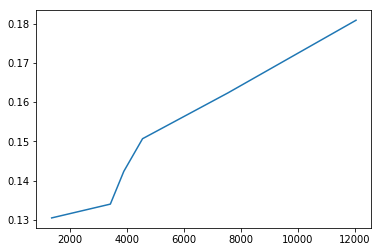

In [20]:
import matplotlib.pyplot as plt
plt.plot(sparsity,error)
print(sparsity)
print(error)

## Observation:
- as the lambda value decreases both error and sparsity are increasing
- as we can the sparsity values above that are increasing with the increase in C values
- the error is also increasing as we can clearly conclude from the above plot

## Feature-importance 

In [21]:
ex=a.coef_
print(ex)
print(X_train.shape)
print(type(X_train))

[[-1.14856929  0.03889894  0.35807846 ... -0.04312506 -0.15013147
   0.03533445]]
(12588, 27671)
<class 'pandas.core.frame.DataFrame'>


In [22]:
import sys
e=sys.float_info.epsilon


- adding an epsilon value to a cell for checking multicolinearity

In [23]:
print(X_train.iloc[76][456])
X_train.iloc[76][456]=X_train.iloc[76][456]+e

0.0


In [24]:
X_train.iloc[76][456]

2.220446049250313e-16

In [25]:
clft=LogisticRegression(penalty='l1')
clft.fit(X_train,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
ex1=np.array(clft.coef_)
ex=np.array(a.coef_)
print(ex1.shape)
print(ex.shape)
ex[:,10]

(1, 27671)
(1, 27671)


array([0.01395185])

In [27]:
condn=[]
for i in range(25119):
    con=abs((ex[:,i]-ex1[:,i])/ex[:,i])
    condn.append(con)
    
    


C:\Users\santosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
ex=list(ex)
ex1=list(ex1)
condn=list(condn)
print("the maximum effect is ",max(condn))
print(condn.index(min(condn)))

the maximum effect is  [12.10827765]
1384


C:\Users\santosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
C:\Users\santosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


## Observation:
- on adding epsilon to a cell the difference between the feature weights are very high so we can conclude that there exist multicollinearity
- the most important feature is feature-1384

## Performing The above process on TFIDF

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(x)
final_tf_idf.get_shape()
data=final_tf_idf

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data, y, train_size=.9)

C:\Users\santosh\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [38]:
lr=LogisticRegression()
model = GridSearchCV(lr, tuned_parameters, scoring = 'accuracy')
model.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.01, 1, 100, 10000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [39]:
tuned_parameters1 = {'C': [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
model1 = RandomizedSearchCV(lr, tuned_parameters1, scoring = 'accuracy')
model1.fit(X_train, y_train)


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [40]:
a=model.best_estimator_
b=model1.best_estimator_
print(a)
print(b)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [41]:
from sklearn.metrics import accuracy_score
pred=a.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True)* float(100)
pred1=b.predict(X_test)
acc1 = accuracy_score(y_test, pred1, normalize=True) * float(100)
print("test accuracy by gridsearchCV is %d", acc)
print("test accuracy by randomsearchCV is %d", acc1)

test accuracy by gridsearchCV is %d 90.21678710394664
test accuracy by randomsearchCV is %d 90.21678710394664


In [42]:
clf=LogisticRegression(penalty='l1')
clf.fit(X_train,y_train)
pred2=clf.predict(X_test)
acc2 = accuracy_score(y_test, pred2, normalize=True) * float(100)
print("test accuracy with L1 regularizer %d", acc2)

test accuracy with L1 regularizer %d 86.49249583101724


In [43]:
#from L-1 Regularizer
confusion_matrix(y_test,pred2)


array([[ 515,  147],
       [  96, 1041]], dtype=int64)

In [44]:
#from L-2 Regularizer
confusion_matrix(y_test,pred1)

array([[ 565,   97],
       [  79, 1058]], dtype=int64)

In [45]:
sparsity=[]
error=[]
mylist=[1,10,10**2,10**3,10**4,10**5]
for i in mylist:
    clf=LogisticRegression(C=i,penalty='l1')
    clf.fit(X_train,y_train)
    pred2=clf.predict(X_test)
    acc2 = accuracy_score(y_test, pred2, normalize=True)
    er=1-acc2
    error.append(er)
    w = clf.coef_
    sparsity.append(np.count_nonzero(w))

    
    

[443, 3398, 4715, 8419, 14523, 51263]
[0.13507504168982765, 0.09949972206781543, 0.10561423012784876, 0.10116731517509725, 0.0961645358532518, 0.13062812673707613]


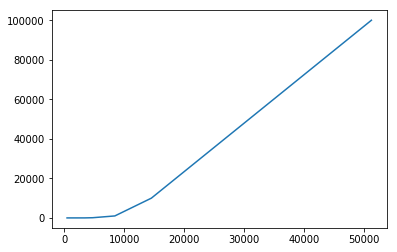

In [46]:
import matplotlib.pyplot as plt
plt.plot(sparsity,mylist)
print(sparsity)
print(error)

## Observation:
- as we can see the sparsity increases upon the increase in C value
- as the error varies but the sparsity keeps increasing

# CONCLUSION:

In [48]:
from ipywidgets import *
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["VECTORIZER","Optimal C","L2-Test accuracy","L1-Test Accuracy"]

x.add_row(["BOW",1,87,86])
x.add_row(["TFIDF",10000,90,86])

print(x)

+------------+-----------+------------------+------------------+
| VECTORIZER | Optimal C | L2-Test accuracy | L1-Test Accuracy |
+------------+-----------+------------------+------------------+
|    BOW     |     1     |        87        |        86        |
|   TFIDF    |   10000   |        90        |        86        |
+------------+-----------+------------------+------------------+


## Key-points:
-  as we can clearly see that logistic regression is best for 2 Class classification problem through the results.
-  the accuracies are good with above 85%
-  one of the key point here is that we observe as the hyper parameter value increases the sparsity increases.
-  Similarly on the increase of the hyper parameter the error also increases.
-  this shows that it is best for low hyper parameter values.
-  we got the optimal hyper parameters from both gridsearchCv and RandomsearchCv as 1 for Bag of words and 100 for TFIDF.
-  In the process of getting the best feature we went through Multi-collinearity.
-  The best Feature is feature-1384 which does not effect the results most upon adding a small error into the data.
